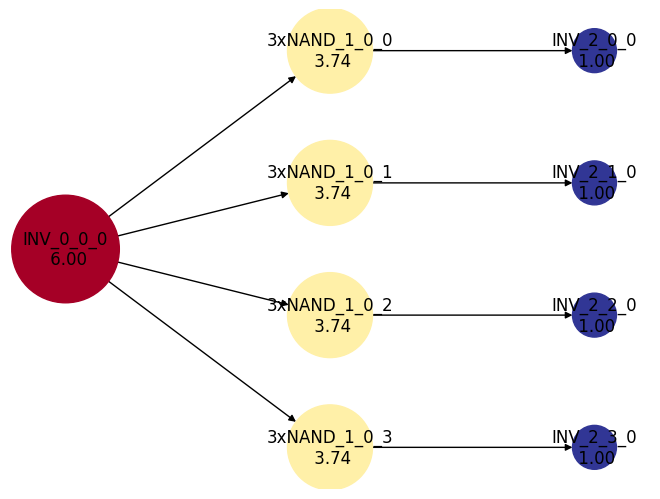

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from pylab import rcParams

manualinput = False

class gate:
    def __init__(self,type):
        self.children = []
        self.type = type
        self.layer = 0
        self.number = 0
        self.branch = 0
        if type == "INV":
            self.P = 1
            self.g = 1 
            self.Co = 4
            self.Ci = 4
        elif type == "NAND":
            self.P = 2
            self.g = 4/3
            self.Co = 6 
            self.Ci = 4 
        elif type == "3xNAND":
            self.P = 3
            self.g = 5/3
            self.Co = 9
            self.Ci = 5
        self.wirecap = 0
    def generatename(self):
        self.name = self.type +"_" + str(self.layer) + "_" + str(self.branch) + "_" + str(self.number)

    def add_downstream(self, obj):
        self.children.append(obj)
    
    def calculate_delays(self):
        Cext = self.wirecap 
        for child in self.children:
            Cext+=child.Ci
        f = Cext/self.Co
        self.delay = self.P + self.g*f
        if (self.wirecap>0):
            self.name = self.name + "\n Cw = " + str(self.wirecap)
        self.name = self.name + "\n {:.2f}".format(self.delay)
        for child in self.children:
            child.calculate_delays()

    
    def plotDelays(self, graph):
        graph.add_node(self.name,delay=self.delay)
        for child in self.children:
            graph.add_edge(self.name, child.name)
            child.plotDelays(graph)
        return graph

def plot_graph(root):
    graph = nx.DiGraph()
    graph.add_node(root.name,delay=root.delay)
    graph = root.plotDelays(graph)
    magnitudes = [data['delay'] for _, data in graph.nodes(data=True)]

    # Define the colormap (blue to red)
    colormap = plt.colormaps.get_cmap('RdYlBu_r')  # You can choose other colormaps as well

    # Normalize the magnitudes to the range [0, 1] to fit the colormap
    norm_magnitudes = [(mag - min(magnitudes)) / (max(magnitudes) - min(magnitudes)) for mag in magnitudes]

    pos=graphviz_layout(graph, prog='dot', args='-Grankdir=LR')
    nx.draw(graph, pos, with_labels=True,node_size=[v * 1000 for v in magnitudes],arrows=True,node_color=norm_magnitudes, cmap=colormap)
    plt.show()

       

#Allow a user to input a tree structure
def fill_tree(obj):
    fanout = int(input("Enter fanout for {}".format(obj.type)))
    for i in range(fanout):
        child = gate(input("Enter gate type for gate #{}".format(i)))
        child.number = i
        child.layer = obj.layer + 1
        child.branch = obj.number
        child.generatename()
        obj.add_downstream(child)
    for child in obj.children:
        child = fill_tree(child)
    return obj

def fill_layer(obj,type,count):
    for i in range(count):
        child = gate(type)
        child.number = i
        child.layer = obj.layer + 1
        child.branch = obj.number
        child.generatename()
        obj.add_downstream(child)
    return obj

def generate38decoder(NANDcount,INVcount):
    root = gate("INV")
    root.number = 0
    root.layer = 0
    root.wirecap = 0
    root.generatename()
    root = fill_layer(root,"3xNAND",NANDcount)
    for child in root.children:
        child = fill_layer(child,"INV",INVcount)
    return root

if manualinput:
    root = gate("INV")
    root.number = 0
    root.layer = 0
    root.generatename()
    root = fill_tree(root)
else:
    root = generate38decoder(4,1)

root.calculate_delays()
plot_graph(root)
